In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import lib.myfunc2 as myf

In [2]:
def print_bar_vaules_percent(plot, no_of_bars):
    prev = [0] * no_of_bars
    pos = 0
    for p in plot.patches:
        if prev[pos] != p.get_height():
            plot.annotate(str(p.get_height())+'%', (p.get_x() * 1.005, p.get_height() * 1.005))
            prev[pos] = p.get_height()
        pos += 1
        pos = pos % no_of_bars

        
def print_bar_vaules(plot, no_of_bars):
    prev = [0] * no_of_bars
    pos = 0
    for p in plot.patches:
        if prev[pos] != p.get_height():
            plot.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
            prev[pos] = p.get_height()
        pos += 1
        pos = pos % no_of_bars

In [3]:
ackNER_findings = pd.read_csv('./AckNER/ne.csv', encoding='utf-8', dialect='excel')
testset = pd.read_csv('./testset/EconStor_test_set.csv', encoding='utf-8', dialect='excel-tab')

In [4]:
ackNER_handles = ackNER_findings.handle
ackNER_handles.drop_duplicates(keep='first', inplace=True)
ackNER_handles = ackNER_handles.reset_index(drop=True)

In [5]:
testset_unknown = testset[testset['funder'] == 'U']
testset_oa = testset[testset['funder'] == 'OA']
testset_nofunder = testset[testset['funder'] == 'N']
testset_funder = testset[testset['funder'] == 'Y']
testset_negativ = testset[(testset['funder'] == 'U') | (testset['funder'] == 'OA') | (testset['funder'] == 'N')]
#testset_negativ = testset_unknown.append(testset_oa).append(testset_nofunder)
print(f"No. of items with unclear status 'funder=U': {testset_unknown.handle.size}")
print(f"No. of items with OpenAccess grant 'funder=OA': {testset_oa.handle.size}")
print(f"NO. of items with no funder given 'funder=N': {testset_nofunder.handle.size}")
print(f"No. of items we define to have no funder 'funder=U|OA|N': {testset_negativ.handle.size}")

No. of items with unclear status 'funder=U': 9
No. of items with OpenAccess grant 'funder=OA': 6
NO. of items with no funder given 'funder=N': 73
No. of items we define to have no funder 'funder=U|OA|N': 88


In [6]:
ackNER_false_all = ackNER_findings[ackNER_findings['handle'].isin(testset_negativ.handle)]
ackNER_false = ackNER_false_all[ackNER_false_all['ne'].str.match('^(?!(grant)|(Number)|(Agreement))' ,case=False)]
ackNER_false_handle = (ackNER_false.handle).drop_duplicates(keep='first', inplace=False).reset_index(drop=True)
print(f'no of items of the set of items with no funders for which AckNER has returned a funder: {ackNER_false_handle.size}')
print(f'no of all funders returned from AckNER for the set of items with no funders: {ackNER_false.handle.size}')

no of items of the set of items with no funders for which AckNER has returned a funder: 17
no of all funders returned from AckNER for the set of items with no funders: 48


In [7]:
ackNER_positive = ackNER_findings[ackNER_findings['handle'].isin(testset_funder.handle)]
ackNER_positive_handle = (ackNER_positive.handle).drop_duplicates(keep='first', inplace=False).reset_index(drop=True)
print(f'no of items from unfiltered AckNER results for items with funder in testset : {ackNER_positive_handle.size}')
print(f'no of unfiltered AckNER results for items with funder in testset: {ackNER_positive.handle.size}')

no of items from unfiltered AckNER results for items with funder in testset : 477
no of unfiltered AckNER results for items with funder in testset: 1699


In [8]:
# do a left join of the testset by handle on the AckNER findings (already filtered for items with funder in test set funder=Y)
ackNER_funder_merge = pd.merge(ackNER_positive, testset_funder, how="left", on="handle")

In [9]:
# filter for Results with grant number only
ackNER_funder_merge_grant_no = ackNER_funder_merge[ackNER_funder_merge['ne'].str.match('^(grant)|(Number)|(Agreement)' ,case=False)]

#filter for Results with Funder info
ackNER_funder_merge_funder_only = ackNER_funder_merge[ackNER_funder_merge['ne'].str.match('^(?!(grant)|(Number)|(Agreement))' ,case=False)]

In [10]:
print(f"No. of possible funder by AckNER: {ackNER_funder_merge_funder_only.index.size}")
print(f"No. of possible grant numbers found by AckNER: {ackNER_funder_merge_grant_no.index.size}")

No. of possible funder by AckNER: 1473
No. of possible grant numbers found by AckNER: 226


In [11]:
ackNER_funder_merge_funder_only_handles = ackNER_funder_merge_funder_only.handle
ackNER_funder_merge_funder_only_handles = ackNER_funder_merge_funder_only_handles.drop_duplicates(keep='first')
ackNER_funder_merge_funder_only_handles = ackNER_funder_merge_funder_only_handles.reset_index(drop=True)

In [12]:
# filter for duplicate findings by AckNER per item (handle)
allmychosenrows = []
for handle in ackNER_funder_merge_funder_only_handles:
    handle_rows = ackNER_funder_merge_funder_only[ackNER_funder_merge_funder_only.handle == handle]
    chosenrows = myf.deduplicate_row_by_value(handle_rows, 'ne')
    if len(chosenrows) > 0:
        allmychosenrows.extend(chosenrows)
        
deduplicated_answers_df = pd.DataFrame(data=allmychosenrows)

In [13]:
import re

positive_match_rows = []
false_positive_match_rows = []
for row in deduplicated_answers_df.itertuples():
    #is_answer = myf.compare_answers(row.ne, row.pdf_phrase)
    is_answer = myf.compare_answers(re.sub(r'\s+-\s+','-',row.ne), re.sub(r'\s+-\s+','-',row.pdf_phrase))
    if is_answer:
        positive_match_rows.append(row)
        #print(f"{row.handle}, True, {row.ne}")
    else:
        false_positive_match_rows.append(row)
        #print(f"{row.handle}, False, \"{row.ne}\" != \"{row.pdf_phrase}\"")
        
positive_match_df = pd.DataFrame(data=positive_match_rows)
false_positive_match_df = pd.DataFrame(data=false_positive_match_rows)

no_of_positive_matches = positive_match_df.index.size
print(f"No. of positive matches: {no_of_positive_matches}")
no_of_false_positive_matches = false_positive_match_df.index.size
print(f"No. of false positive matches: {no_of_false_positive_matches}")
no_of_positive_matched_items = (positive_match_df.handle).drop_duplicates(keep='first', inplace=False).size
print(f"No. of items with positive match: {no_of_positive_matched_items}")
no_of_false_positive_matched_items = (false_positive_match_df.handle).drop_duplicates(keep='first', inplace=False).size
print(f"No. of items with false positive match: {no_of_false_positive_matched_items}")

No. of positive matches: 858
No. of false positive matches: 345
No. of items with positive match: 319
No. of items with false positive match: 144


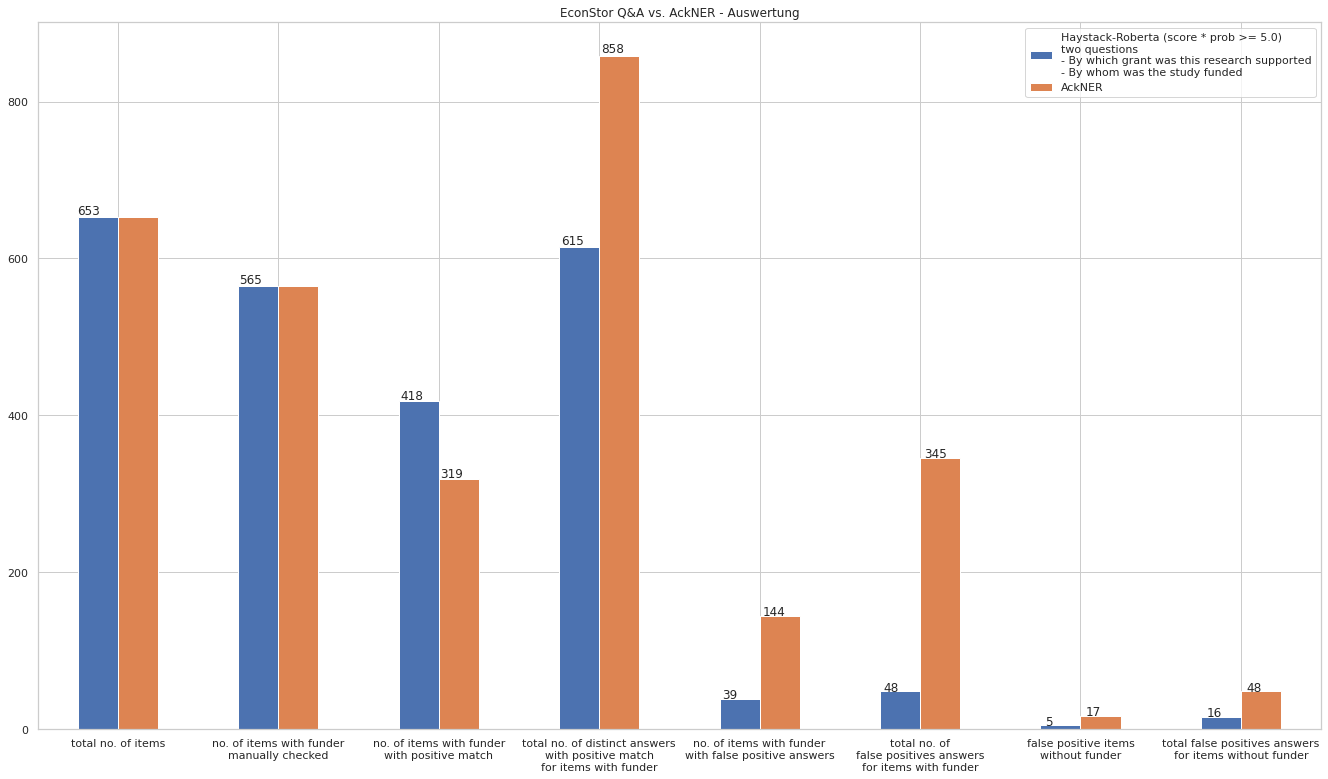

In [14]:
name_haystack = 'Haystack-Roberta (score * prob >= 5.0)\ntwo questions\n- By which grant was this research supported\n- By whom was the study funded'
name_ackner = 'AckNER'
result_haystack = { 'total no. of items': 653,
                    'no. of items with funder\nmanually checked': 565,
                    'no. of items with funder\nwith positive match': 418,
                    'total no. of distinct answers\nwith positive match\nfor items with funder': 615,
                    'no. of items with funder\nwith false positive answers': 39,
                    'total no. of\nfalse positives answers\nfor items with funder': 48,
                    'false positive items\nwithout funder': 5,
                    'total false positives answers\nfor items without funder': 16
                    
}
result_ackner = {   'total no. of items': 653,
                    'no. of items with funder\nmanually checked': 565,
                    'no. of items with funder\nwith positive match': no_of_positive_matched_items,
                    'total no. of distinct answers\nwith positive match\nfor items with funder': no_of_positive_matches,
                    'no. of items with funder\nwith false positive answers': no_of_false_positive_matched_items,
                    'total no. of\nfalse positives answers\nfor items with funder': no_of_false_positive_matches,
                    'false positive items\nwithout funder': ackNER_false_handle.size,
                    'total false positives answers\nfor items without funder': ackNER_false.handle.size
}
series_result_haystack = pd.Series(result_haystack)
series_result_ackner = pd.Series(result_ackner)
df_hay_ack_1 = pd.DataFrame({name_haystack: series_result_haystack, name_ackner: series_result_ackner})
sns.set(style="whitegrid")
plot1 = df_hay_ack_1.plot.bar(figsize=(23, 13), 
                                       title='EconStor Q&A vs. AckNER - Auswertung',
                                       rot=0)
print_bar_vaules(plot1, 8)